import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from platypus import Solution, Hypervolume, Archive

from besos import eppy_funcs as ef
from besos.problem import EPProblem
from besos.evaluator import EvaluatorEP
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from besos.optimizer import NSGAII, df_solution_to_solutions
import besos.sampling as sampling

# Building Optimization

This notebook performs building design optimization using EnergyPlus and BESOS helper functions.  
We load a model from in.idf, define parameters to vary, set objectives, test the model, then run a multi-objective genetic algorithm and plot the optimized designs.

## Load the base EnergyPlus .idf file

In [2]:
building = ef.get_building('in.idf') # Load the E+ model in.idf

## Define design parameters and ranges

In [3]:
parameters = []
parameters = expand_plist( # Use helper function to make parameter list
    {'Building 1':                    # Name from IDF Building object
          {'North Axis':(0,359)}}     # Change orientation from North
    )

parameters.append(wwr(RangeParameter(0.1, 0.9))) # Add window-to-wall ratio as a parameter between 0.1 and 0.9 using a custom function

## Objectives

In [4]:
objectives = ['DistrictCooling:Facility', 'DistrictHeating:Facility'] # Use Heating and Cooling (Ideal air loads) as objectives
besos_problem = EPProblem(parameters, objectives) # Make a problem instance from the parameters and objectives

## Set up EnergyPlus evaluator object to run simulations for this building and problem

In [5]:
evaluator = EvaluatorEP(besos_problem, building, out_dir='outputdir', err_dir='outputdir') # outputdir must exist; E+ files will be written there
runs = pd.DataFrame.from_dict({'0': [180, 0.5]}, orient='index') # Make a dataframe of runs with one entry for South and 50% glazing
outputs = evaluator.df_apply(runs) # Run this as a test
outputs

,DistrictCooling:Facility,DistrictHeating:Facility
0,3.233564e+09,4.931726e+09


## Run the Genetic Algorithm

In [6]:
results = NSGAII(evaluator, evaluations=10, population_size=20) # Run the optimizer using this evaluator for a population size of 20 for 10 generations
results

,North Axis,Window to Wall Ratio,DistrictCooling:Facility,DistrictHeating:Facility,violation,pareto-optimal
0,219.736012,0.366591,3.670680e+09,4.105240e+09,0,True
1,341.689391,0.753917,4.384993e+09,4.454563e+09,0,False
2,293.310689,0.365404,4.478613e+09,3.306264e+09,0,False
3,132.107603,0.474162,3.714934e+09,4.720824e+09,0,False
4,194.873295,0.748354,3.262466e+09,6.277199e+09,0,True
5,100.062693,0.112733,4.159768e+09,2.504805e+09,0,True
6,287.868263,0.320296,4.455796e+09,3.158007e+09,0,False
7,93.782115,0.741189,4.283482e+09,5.654314e+09,0,False
8,107.477031,0.609360,4.074610e+09,5.183066e+09,0,False
9,291.392762,0.758171,4.590945e+09,5.140236e+09,0,False


## Visualize the results

Text(0, 0.5, 'Heating demand')

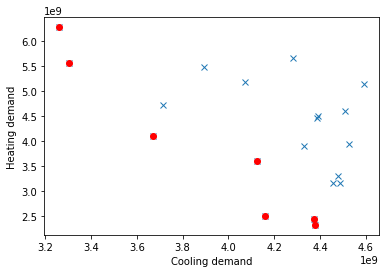

In [7]:
optres = results.loc[results['pareto-optimal']==True,:] # Get only the optimal results
plt.plot(results['DistrictCooling:Facility'], results['DistrictHeating:Facility'],'x') # Plot all results in the background
plt.plot(optres['DistrictCooling:Facility'], optres['DistrictHeating:Facility'],'ro') # Plot optimal results in red
plt.xlabel('Cooling demand')
plt.ylabel('Heating demand')

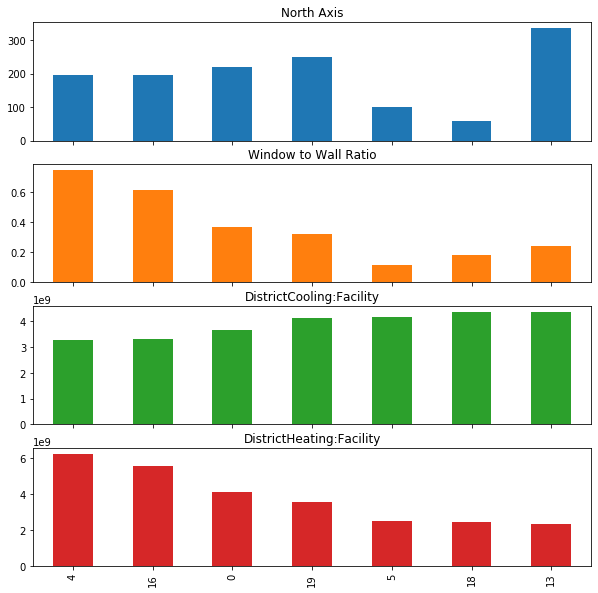

In [8]:
optres = optres.sort_values('DistrictCooling:Facility') # Sort by the first objective 
optresplot = optres.drop(columns='violation') # Remove the constraint violation column
ax=optresplot.plot.bar(subplots=True,legend=None,figsize=(10,10)) # Plot the variable values of each of the optimal solutions

## Hypervolume

### Run the Genetic Algorithm again

In [15]:
results_2 = NSGAII(evaluator, evaluations=20, population_size=50)

### Compare first run and second run

Text(0, 0.5, 'Heating demand')

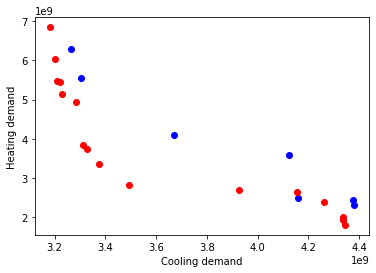

In [16]:
optres_2 = results_2.loc[results_2['pareto-optimal']==True,:]
plt.plot(optres['DistrictCooling:Facility'], optres['DistrictHeating:Facility'],'bo') # Plot first optimal results in blue
plt.plot(optres_2['DistrictCooling:Facility'], optres_2['DistrictHeating:Facility'],'ro') # Plot second optimal results in red
plt.xlabel('Cooling demand')
plt.ylabel('Heating demand')

### Calculate the hypervolume

In [18]:
reference_set = Archive()
platypus_problem = evaluator.to_platypus()
for _ in range(20):
    solution = Solution(platypus_problem)
    solution.variables = sampling.dist_sampler(sampling.lhs, besos_problem, 1).values.tolist()[0]
    solution.evaluate()
    reference_set.add(solution)

hyp = Hypervolume(reference_set)
print("Hypervolume for result 1:", hyp.calculate(df_solution_to_solutions(results, platypus_problem, besos_problem)))
print("Hypervolume for result 2:", hyp.calculate(df_solution_to_solutions(results_2, platypus_problem, besos_problem)))

Hypervolume for result 1: 0.5423242192578384
Hypervolume for result 2: 0.8322520476043208
